In [1]:
from model_cnn import MyNeuralNetwork
import pickle
filename = 'models/best_model.sav'
model = pickle.load(open(filename, 'rb'))

Poddamy krótkiej analizie model osiągający najlepsze wyniki, wytrenowany w zewnętrznym środowisku wykonawczym. Ma on cztery warstwy konwolucyjne w celu ekstrakcji cech obrazów i trzy warstwy liniowe zajmujące się klasyfikacją. 

In [56]:
print(f"Struktura modelu: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Warstwa: {name} | Wielkość: {param.size()} | Wartości : {param[:2]} \n")

Struktura modelu: MyNeuralNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=26, bias=True)
  )
)


Warstwa: conv_layers.0.weight | Wielkość: torch.Size([32, 1, 3, 3]) | Wartości : tensor([[[[ 0.1172, -0.01

In [54]:
from data_functions import get_loaders_weights_and_occurrences, load_data
_, val_loader, _, occurrences = get_loaders_weights_and_occurrences(32)
_, _, X_val, y_val, _ = load_data()

Przeanalizujmy osiągi modelu na zbiorze walidacyjnym

In [55]:
from sklearn.metrics import f1_score
import torch

model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch_data, labels in val_loader:
        outputs = model(batch_data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

f1_scores = f1_score(true_labels, predicted_labels, average=None)
from data_functions import class_mapping
for class_idx, f1 in enumerate(f1_scores):
    print(f'F1 score for class {class_mapping[class_idx]} (occ. = {occurrences[class_mapping[class_idx]]}): {f1:.2f}')

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

F1 score for class A (occ. = 5126): 0.99
F1 score for class B (occ. = 3102): 0.98
F1 score for class C (occ. = 8075): 0.99
F1 score for class D (occ. = 3650): 0.93
F1 score for class E (occ. = 3947): 0.99
F1 score for class F (occ. = 7345): 0.98
F1 score for class G (occ. = 2014): 0.96
F1 score for class H (occ. = 2522): 0.97
F1 score for class I (occ. = 9557): 0.99
F1 score for class J (occ. = 3010): 0.96
F1 score for class K (occ. = 1974): 0.97
F1 score for class L (occ. = 4061): 0.97
F1 score for class M (occ. = 7201): 0.99
F1 score for class N (occ. = 6590): 0.98
F1 score for class O (occ. = 19986): 0.98
F1 score for class P (occ. = 6678): 0.99
F1 score for class Q (occ. = 2084): 0.96
F1 score for class R (occ. = 4058): 0.98
F1 score for class S (occ. = 16611): 0.99
F1 score for class T (occ. = 7856): 0.99
F1 score for class U (occ. = 10081): 0.97
F1 score for class V (occ. = 3710): 0.92
F1 score for class W (occ. = 3756): 0.97
F1 score for class X (occ. = 2217): 0.97
F1 score for 

Wartość współczynnika korelacji (Pearson): 0.42064871522946196


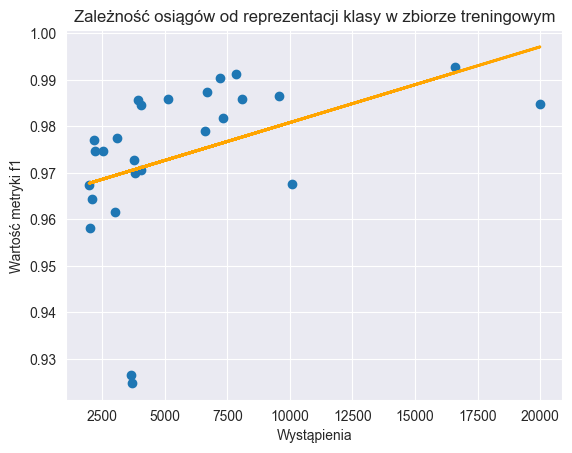

In [52]:
import numpy as np
import matplotlib.pyplot as plt
corr_arr = np.array(
    [[tensor.item() for tensor in occurrences.values()], [tensor.item() for tensor in f1_scores]]).T
print(f'Wartość współczynnika korelacji (Pearson): {np.corrcoef(corr_arr[:, 0], corr_arr[:, 1])[0, 1]}')
z = np.polyfit(list(occurrences.values()),f1_scores,1)
p = np.poly1d(z)
plt.plot(occurrences.values(),p(list(occurrences.values())), color='orange', linewidth=2)
plt.scatter(occurrences.values(), f1_scores)
plt.title(f"Zależność osiągów od reprezentacji klasy w zbiorze treningowym")
plt.xlabel("Wystąpienia")
plt.ylabel("Wartość metryki f1")
plt.show()

Widzimy, że rozpoznawanie *D* i *V* sprawia modelowi szczególnie dużo trudności. Reszta wyników to ok. 98%. 